In [3]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns

from matplotlib import pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
# import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
# from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
# from tslearn.clustering import KShape, silhouette_score

import gc
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest
import math
import warnings
from scipy import stats

In [71]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

In [72]:
#read data
locus_weights=pd.read_csv('evt_movement_ratio_with_dates.csv')
locus_weights.starttime = pd.to_datetime(locus_weights.starttime,format='%Y-%m-%d')
locus_weights.endtime = pd.to_datetime(locus_weights.endtime,format='%Y-%m-%d')

temperature = pd.read_csv('temperature_for_CAM.csv')
temperature.event_date = pd.to_datetime(temperature.event_date,format='%Y-%m-%d')
temperature.locus_group_id=temperature.locus_group_id.astype('int16')
#not sure in row below as it 'converts' 12.3 -> 12.296875
temperature.value=temperature.value.astype('float16')
temperature['event_year']=temperature['event_date'].dt.year

llg_match= pd.read_csv('locus_locus_group_matching.csv')
llg_match.locus_id=llg_match.locus_id.astype('int32')
llg_match.locus_group_id=llg_match.locus_group_id.astype('int16')

df_dates=pd.read_csv('FW_cycle_dates.csv')
for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
    df_dates[d] = pd.to_datetime(df_dates[d],format='%Y-%m-%d')
    
sfm = pd.read_csv('seawater_freshwater_matching.csv')
sfm_ = sfm[sfm.origin_site_type=='Freshwater'][['target_seawater_locus_id','transport_date','ponding_date','pretransfer_fw_locus_population_id','fish_count_shipped_out','avg_weight_g_stocked']]
sfm_.pretransfer_fw_locus_population_id=sfm_.pretransfer_fw_locus_population_id.astype('int64')

df_target=pd.read_csv('tmp_target.csv')
df_target['transfer_date'] = pd.to_datetime(df_target['transfer_date'],format='%Y-%m-%d')
df_target['transport_year']=df_target['transfer_date'].dt.year

lw_alldates_final = pd.read_csv('lw_alldates_final_locus.csv')
# FIX:
lw_alldates_final.event_date = pd.to_datetime(lw_alldates_final.event_date)

In [73]:
lw_dates=locus_weights.groupby('final_locus_population_id').agg({'starttime':'min','endtime':'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime,format='%Y-%m-%d')
lw_dates.endtime = pd.to_datetime(lw_dates.endtime,format='%Y-%m-%d')
#to be checked
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days+1
lw_dates['starttime_year']=lw_dates['starttime'].dt.year
#we limit FW cycles to those started in 2017 because there are issues with temperature readings for 2015-2016
lw_dates_2017=lw_dates[lw_dates.starttime_year>=2017]

In [74]:
lw_alldates_final_=lw_alldates_final.merge(llg_match,left_on='historic_locus_id', right_on='locus_id', how='left')
#alternatively rename column before merging. Thus not having to drop column thereafter
lw_alldates_final_.drop(columns='locus_id',inplace=True)

### co2


In [75]:
co2_data = pd.read_csv('indicators_all_file_joined.csv')
co2_data = co2_data[co2_data.sensor_name == 'Carbon dioxide']
co2_data = co2_data.rename(columns={'event_ts': 'event_date', 'sensor_type_value': 'Carbon_dioxide'})
co2_data.event_date = pd.to_datetime(co2_data.event_date)
# ph_data = ph_data.drop(['sensor_name', 'type_name'], inplace=True)
co2_data.head()

,event_date,locus_group_id,Carbon_dioxide,sensor_name,type_name
68096,2022-01-12,492,7.5,Carbon dioxide,Carbon dioxide
68097,2022-01-12,492,6.5,Carbon dioxide,Carbon dioxide
68098,2022-01-12,492,5.5,Carbon dioxide,Carbon dioxide
68099,2022-01-12,492,6.5,Carbon dioxide,Carbon dioxide
68100,2022-01-12,492,6.5,Carbon dioxide,Carbon dioxide


In [76]:

std_deviation = co2_data.groupby(['locus_group_id', 'event_date'])['Carbon_dioxide'].std()

df_result = pd.DataFrame({'Standard_Deviation': std_deviation})

df_result = df_result.dropna()
df_result_sorted = df_result.sort_values(by='Standard_Deviation', ascending=False)

df_result_sorted.head()


,,Standard_Deviation
locus_group_id,event_date,
490,2022-04-06,492.759745
560,2022-10-12,57.823871
492,2022-09-23,52.915814
557,2022-12-16,4.687750
560,2022-10-26,4.573474


In [77]:
final_locus_weights_co2 = lw_alldates_final_.merge(co2_data, how='left')
final_locus_weights_co2['event_year']=final_locus_weights_co2['event_date'].dt.year


In [78]:
final_locus_weights_co2

,final_locus_population_id,event_date,historic_locus_id,weight,locus_group_id,Carbon_dioxide,sensor_name,type_name,event_year
0,36770651,2015-05-15,3050549,1.0,536,NaN,NaN,NaN,2015
1,36770651,2015-05-16,3050549,1.0,536,NaN,NaN,NaN,2015
2,36770651,2015-05-17,3050549,1.0,536,NaN,NaN,NaN,2015
3,36770651,2015-05-18,3050549,1.0,536,NaN,NaN,NaN,2015
4,36770651,2015-05-19,3050549,1.0,536,NaN,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...
35245477,194650523,2023-02-24,3046268,1.0,555,10.5,Carbon dioxide,Carbon dioxide,2023
35245478,194650523,2023-02-25,3046268,1.0,555,NaN,NaN,NaN,2023
35245479,194650523,2023-02-26,3046268,1.0,555,NaN,NaN,NaN,2023
35245480,194650523,2023-02-27,3046268,1.0,555,NaN,NaN,NaN,2023


In [79]:

final_locus_weights_co2.Carbon_dioxide=final_locus_weights_co2.Carbon_dioxide.astype('float32').round(1)
final_locus_weights_co2['weight_co2']=final_locus_weights_co2['weight']*final_locus_weights_co2['Carbon_dioxide']


In [80]:
final_locus_weights_co2_grouped=final_locus_weights_co2.\
groupby(['final_locus_population_id','event_date'])[['weight_co2']].agg(lambda x: x.sum(skipna=False)).reset_index()
final_locus_weights_co2_grouped.rename(columns={'weight_co2':'Carbon_dioxide'},inplace=True)

In [81]:
final_locus_weights_co2.Carbon_dioxide

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
            ... 
35245477    10.5
35245478     NaN
35245479     NaN
35245480     NaN
35245481     NaN
Name: Carbon_dioxide, Length: 35245482, dtype: float32

In [82]:
# dft=pd.read_csv('../data/lw_alldates_final_grouped.csv')
# dft.event_date = pd.to_datetime(dft.event_date)

#this to interpolate

df_dates_2017=df_dates.merge(
    lw_dates_2017.reset_index()[['final_locus_population_id']],
    left_on='pretransfer_fw_locus_population_id',
    right_on='final_locus_population_id',
    how='inner'
)
df_dates_2017.drop(columns=['final_locus_population_id'], inplace=True)

tmp_list=[]
for ind,row in df_dates_2017.iterrows():
    lp = row.pretransfer_fw_locus_population_id
    start = row.first_movement_date
    end = row.shipout_date
    for d in pd.date_range(start, end):
        tmp_list.append([lp,d])
tmp_df = pd.DataFrame(tmp_list,columns=['final_locus_population_id','event_date'])
dfco2_ = tmp_df.merge(final_locus_weights_co2_grouped, how='left')

In [83]:
output_df_co2 = pd.DataFrame()
for ind,curr_df in dfco2_.groupby('final_locus_population_id'):
    tmp_df=curr_df.copy()
    tmp_df.co2_value=curr_df.Carbon_dioxide.interpolate()
    output_df_co2=pd.concat([output_df_co2,tmp_df])
dft_filled_co2 = output_df_co2.copy()

<ipython-input-83-619fe658caff>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tmp_df.co2_value=curr_df.Carbon_dioxide.interpolate()


In [84]:
dft_filled_co2

,final_locus_population_id,event_date,Carbon_dioxide
0,36783130,2017-01-04,NaN
1,36783130,2017-01-05,NaN
2,36783130,2017-01-06,NaN
3,36783130,2017-01-07,NaN
4,36783130,2017-01-08,NaN
...,...,...,...
1484517,194650523,2023-02-25,NaN
1484518,194650523,2023-02-26,NaN
1484519,194650523,2023-02-27,NaN
1484520,194650523,2023-02-28,NaN


In [85]:
dft_filled_co2[dft_filled_co2.final_locus_population_id == 36791263].Carbon_dioxide.isna().sum()

490

In [86]:
full_cycles = [
    194527129, 
    194497496,
    193247058,
    194516980,
    194546436,
    38193840,
    194352023,
    194503079,
    193343886,
    194530157,
    194497483,
    194503096,
    194522881,
    193249474,
    193247433,
    194523185,
    194512165
]

### Non-smoothed

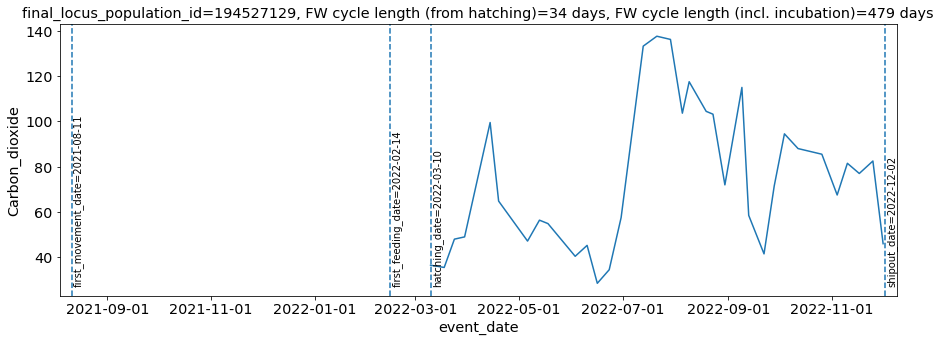

<Figure size 1080x360 with 0 Axes>

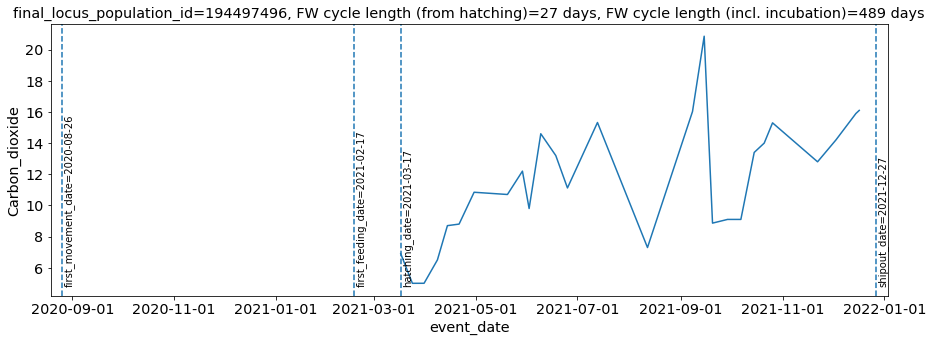

<Figure size 1080x360 with 0 Axes>

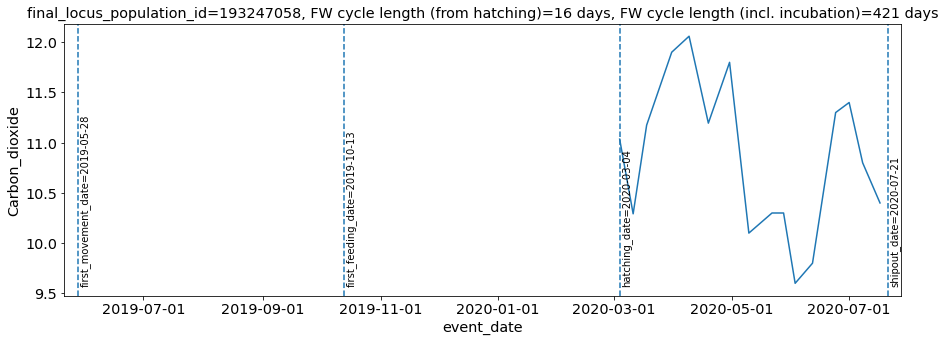

<Figure size 1080x360 with 0 Axes>

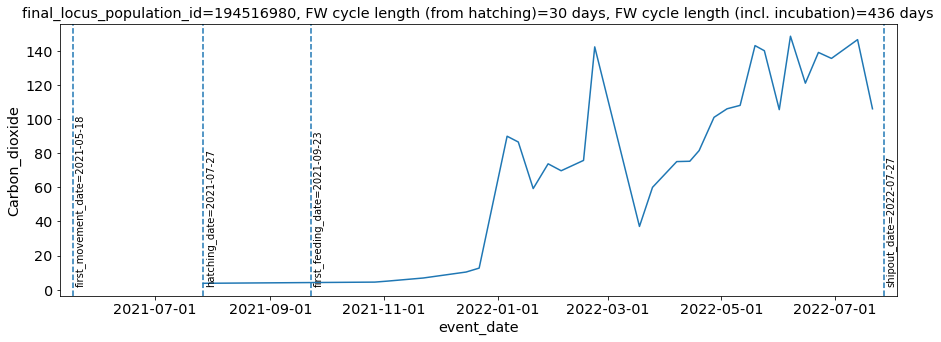

<Figure size 1080x360 with 0 Axes>

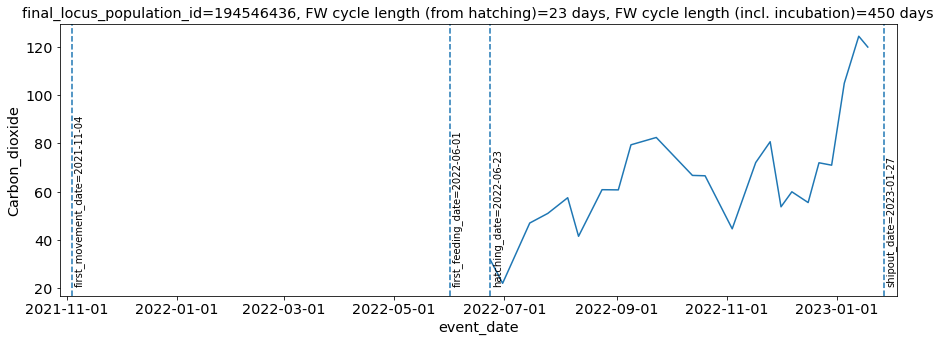

<Figure size 1080x360 with 0 Axes>

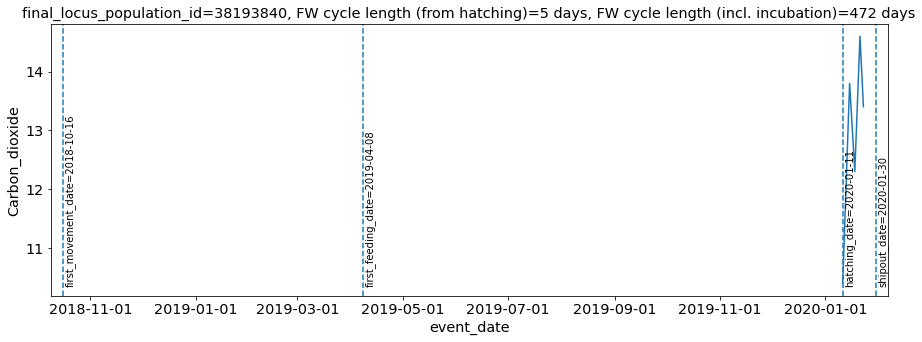

<Figure size 1080x360 with 0 Axes>

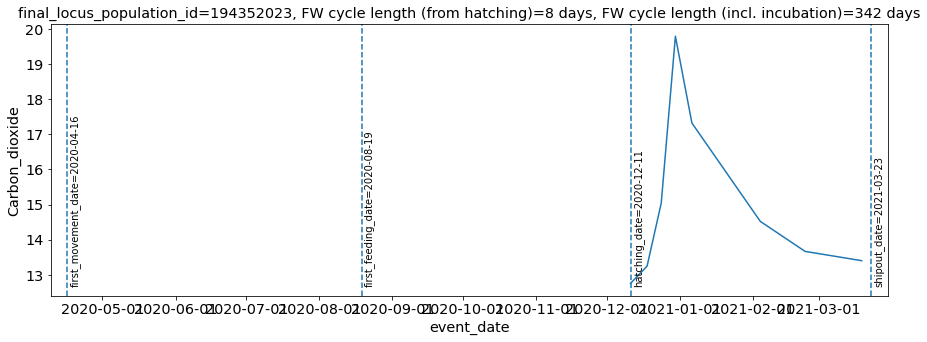

<Figure size 1080x360 with 0 Axes>

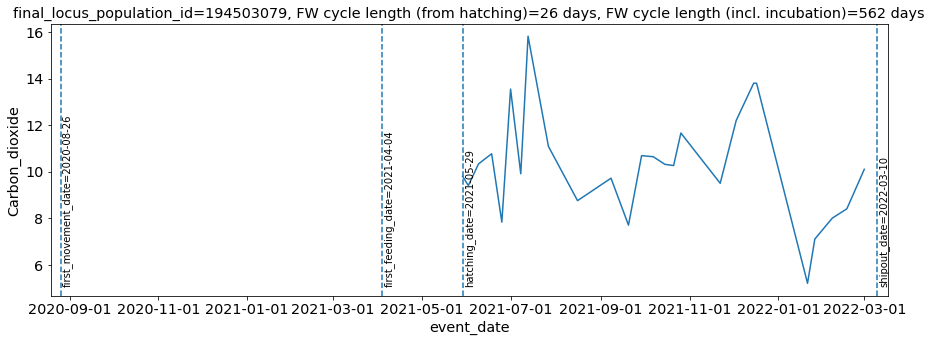

<Figure size 1080x360 with 0 Axes>

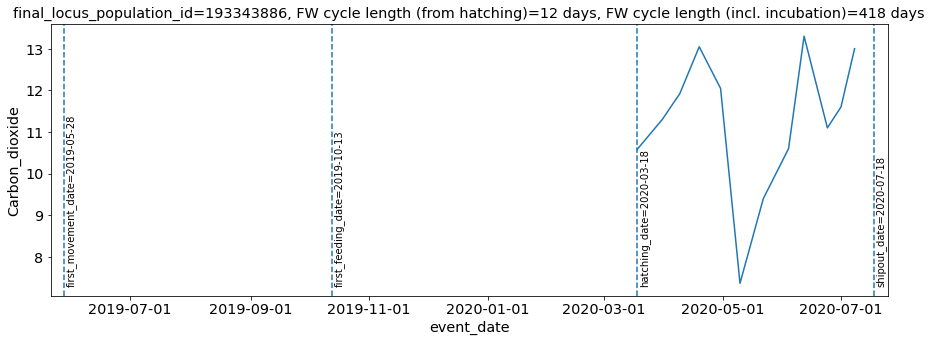

<Figure size 1080x360 with 0 Axes>

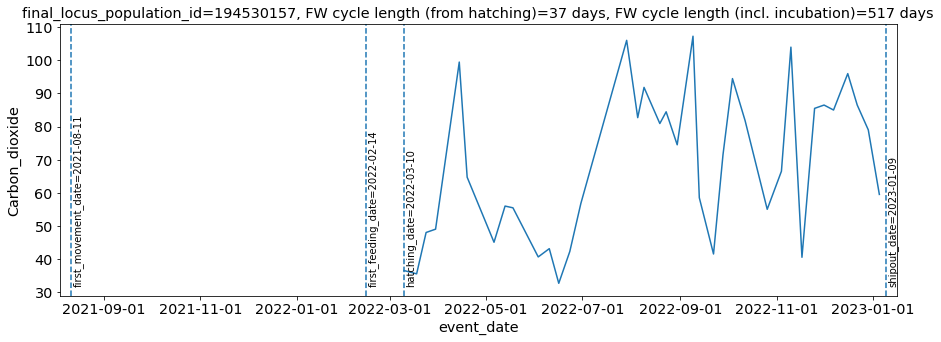

<Figure size 1080x360 with 0 Axes>

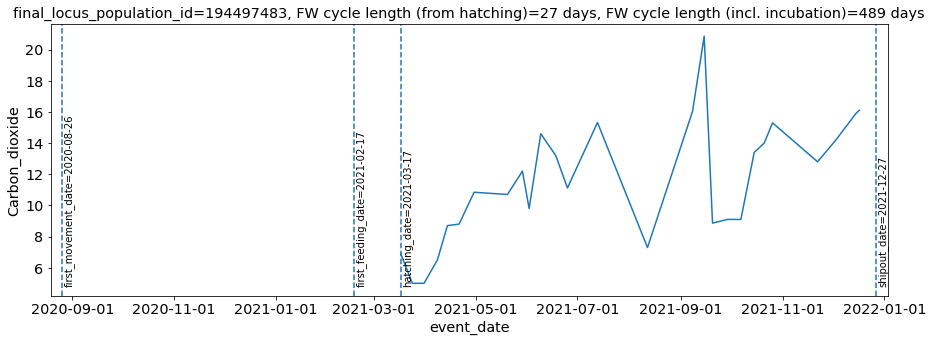

<Figure size 1080x360 with 0 Axes>

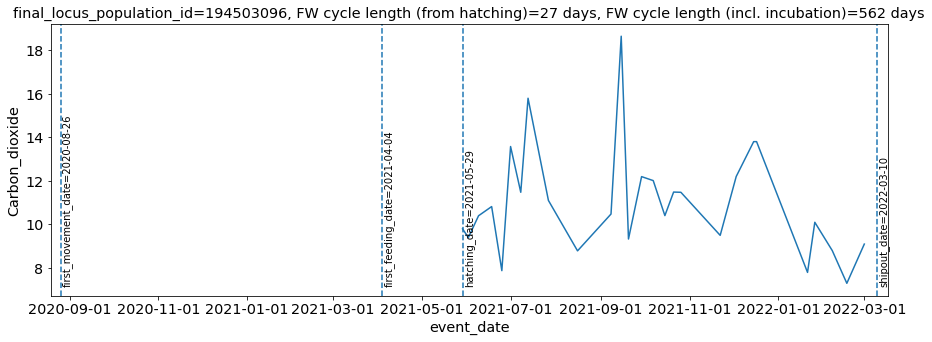

<Figure size 1080x360 with 0 Axes>

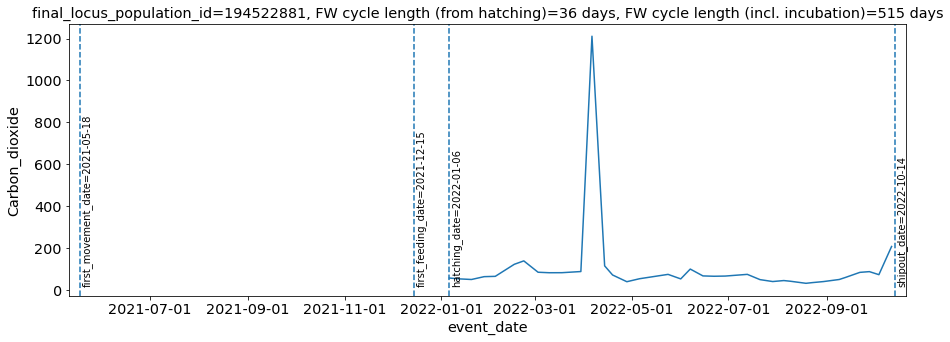

<Figure size 1080x360 with 0 Axes>

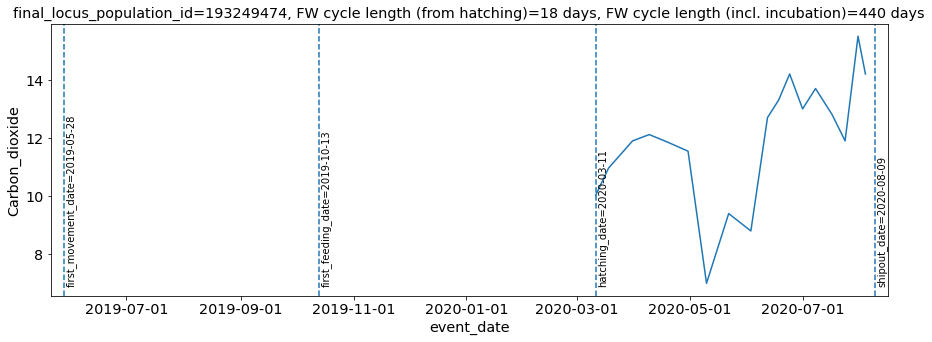

<Figure size 1080x360 with 0 Axes>

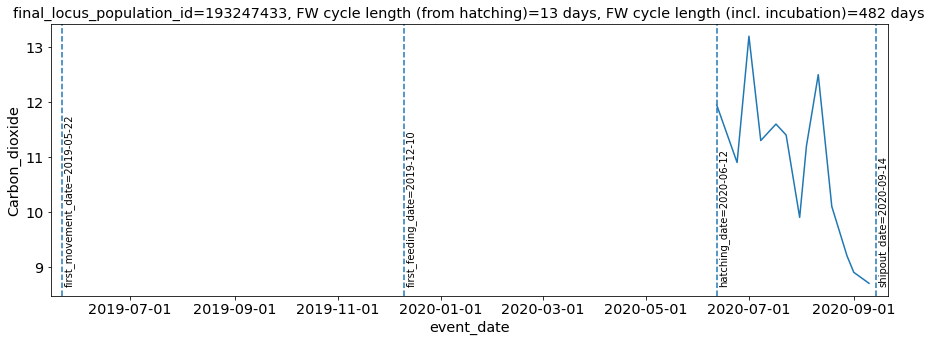

<Figure size 1080x360 with 0 Axes>

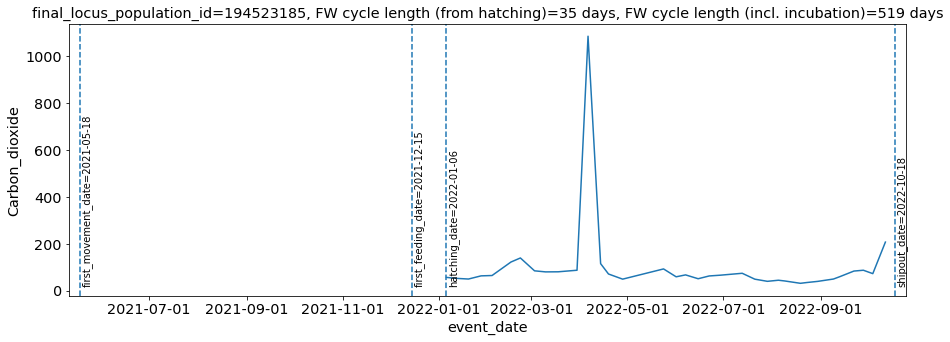

<Figure size 1080x360 with 0 Axes>

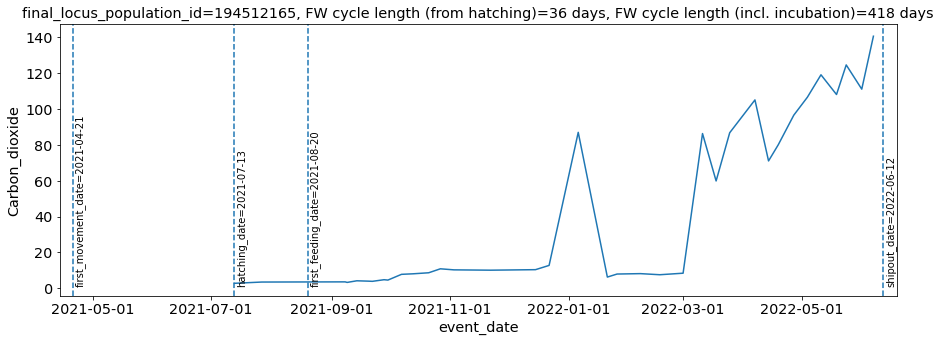

<Figure size 1080x360 with 0 Axes>

In [87]:
#plot temperature time series charts
j=0
for lp in full_cycles:
    filtered_df = dft_filled_co2[dft_filled_co2.final_locus_population_id==lp]
    if filtered_df.Carbon_dioxide.isna().sum() != filtered_df.Carbon_dioxide.shape[0]:
        j+=1
        if (j%100==0): print(j)
        fig, axs = plt.subplots(1, 1)
        sns.lineplot(data=filtered_df, x='event_date',y='Carbon_dioxide')
        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
        plt.title(chart_title)
        min_co2 = filtered_df.Carbon_dioxide.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        plt.xlim(first_movement_date-datetime.timedelta(days=7),shipout_date+datetime.timedelta(days=7))
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            plt.axvline(date, linestyle='--')
            plt.text(date + datetime.timedelta(days=1), min_co2, name+'='+date.strftime("%Y-%m-%d"), rotation=90)
        
        plt.show()
        plt.savefig('Visualisation\\'+chart_title+'.jpg')
        #plt.close()

### Smoothing

In [88]:
def get_mean_last_week(df, x):
    df = df.copy().reset_index()
    idx = df[df.Carbon_dioxide == x].index[0]
    if idx > 7:
        return df.Carbon_dioxide.iloc[idx-7:idx].mean(skipna=True)
    else:
        return df.Carbon_dioxide.iloc[:idx].mean(skipna=True)

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


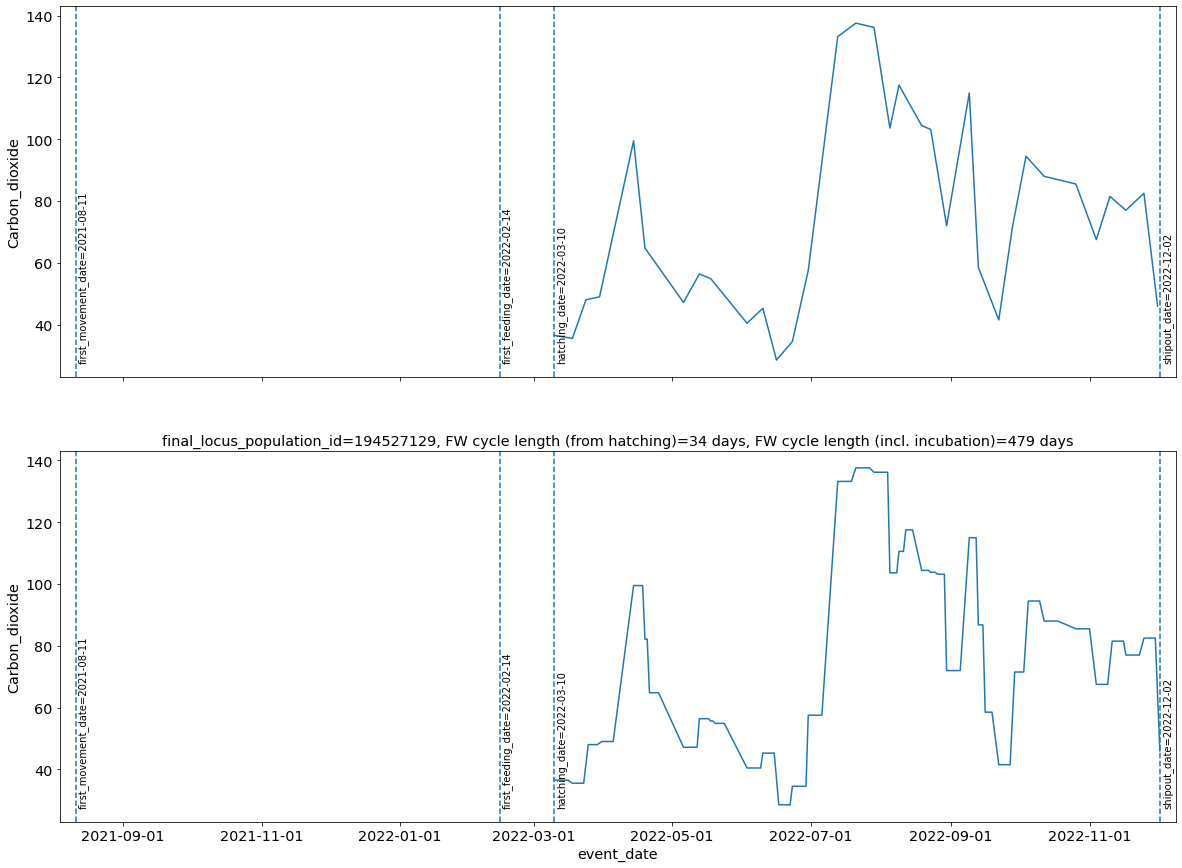

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


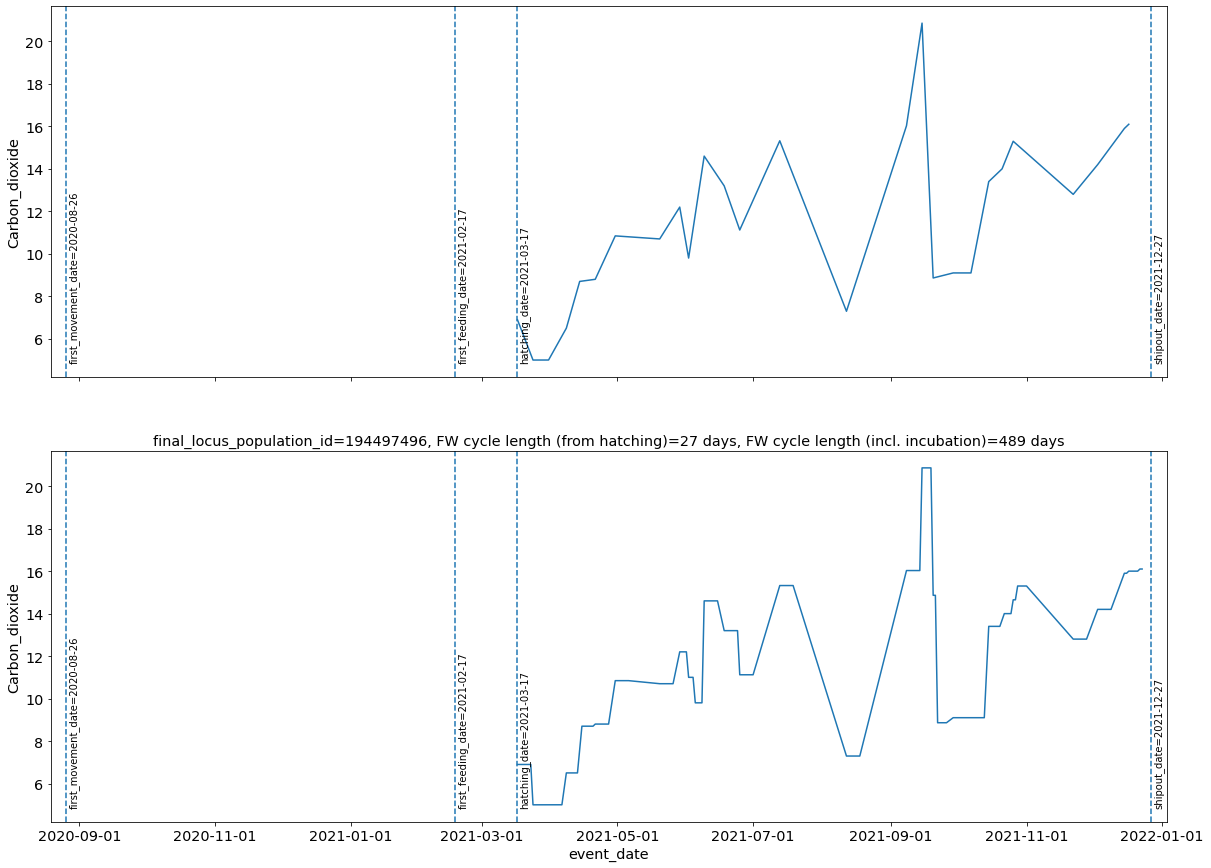

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


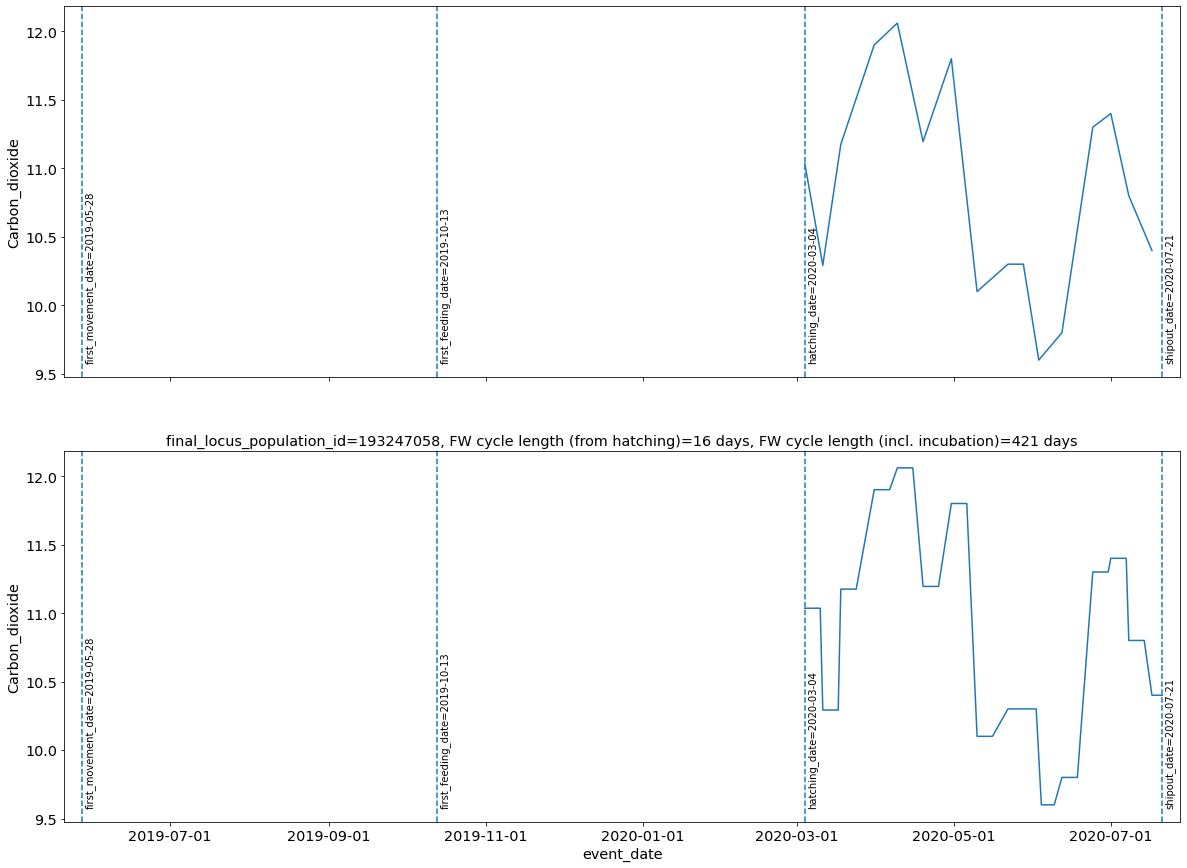

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


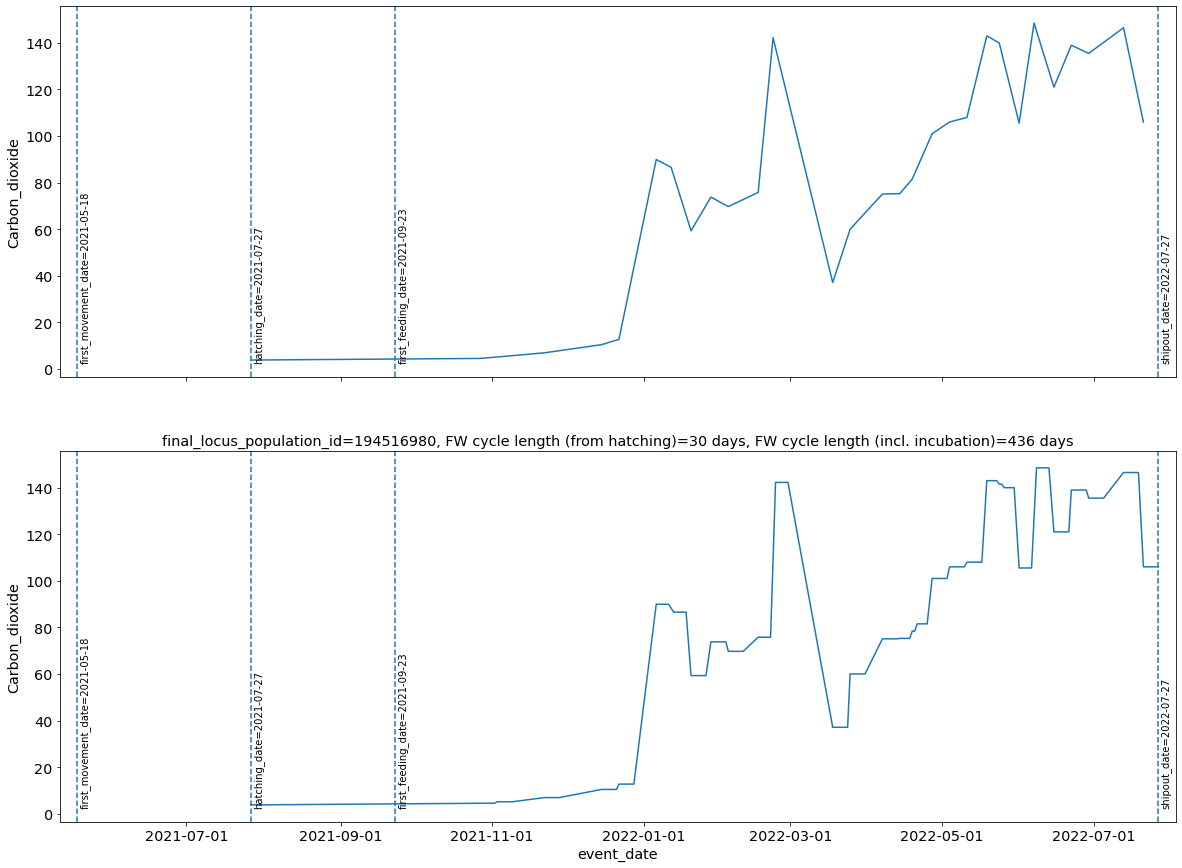

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


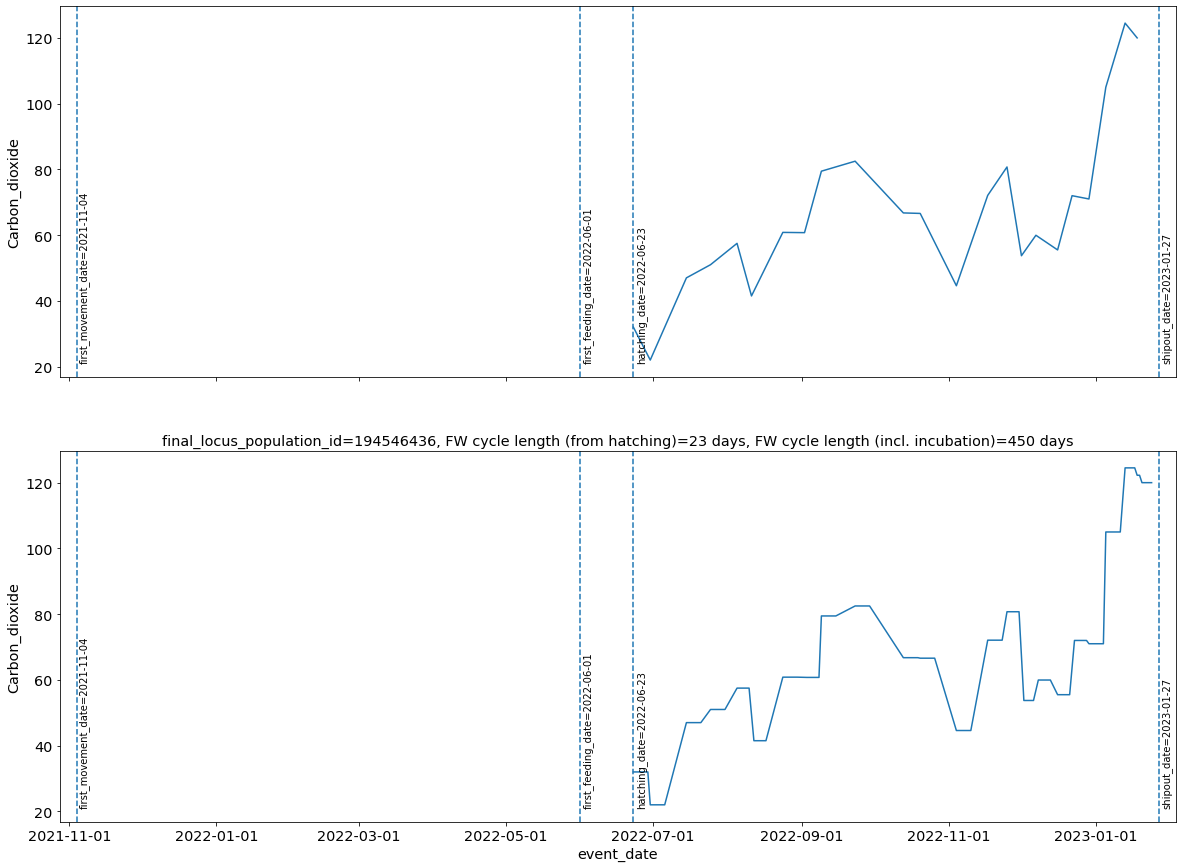

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


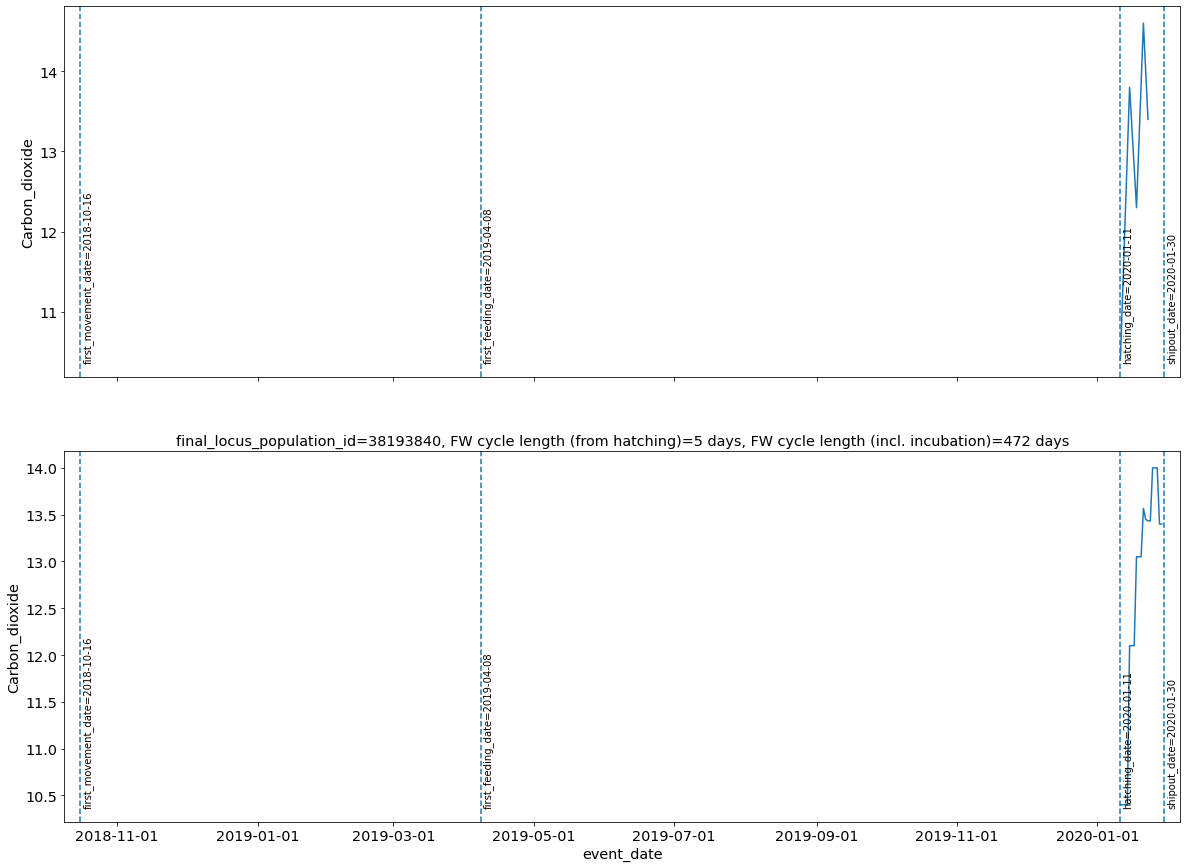

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


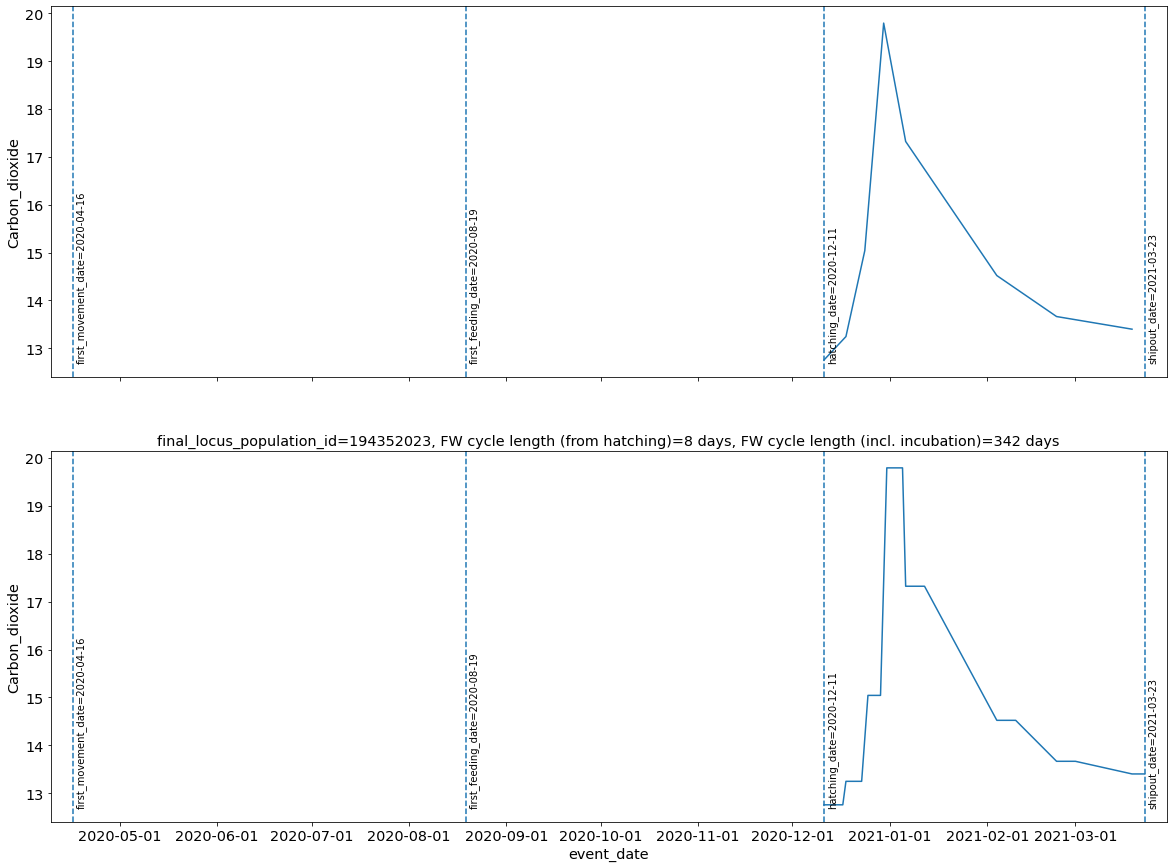

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


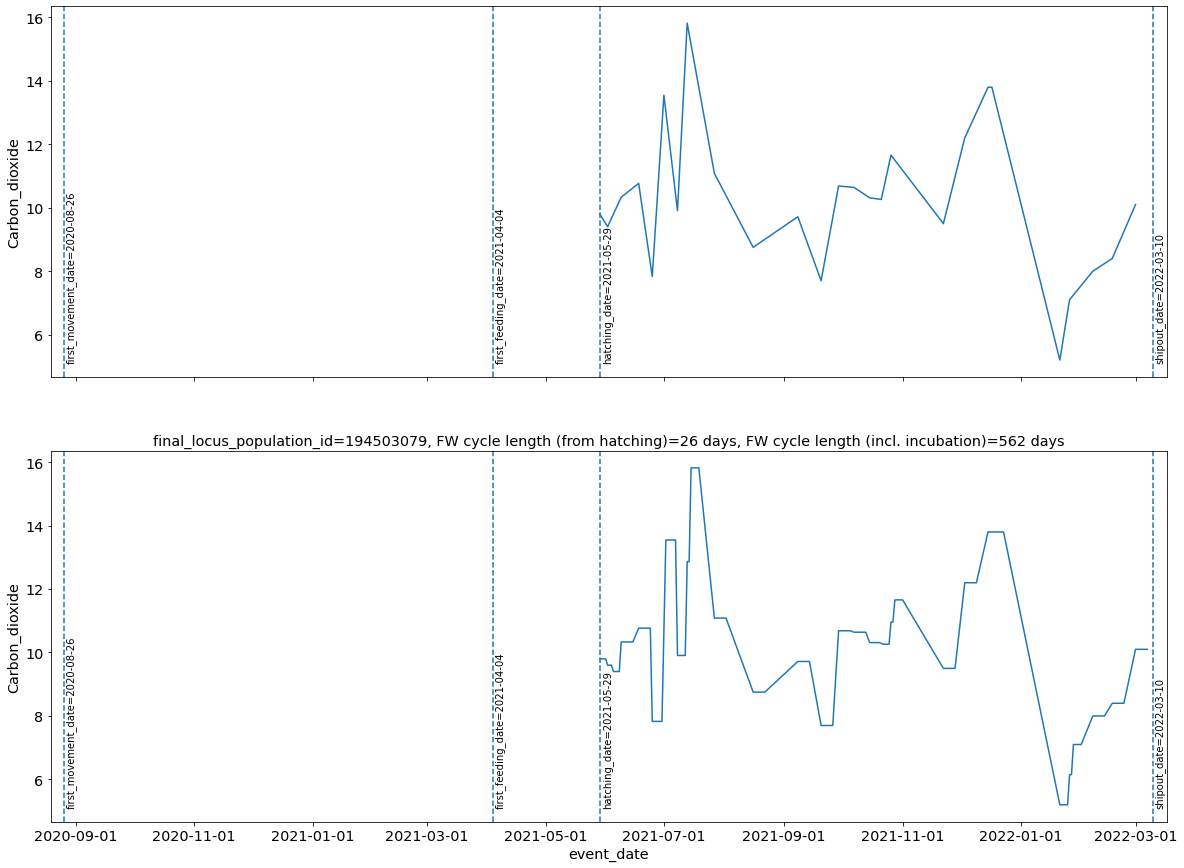

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


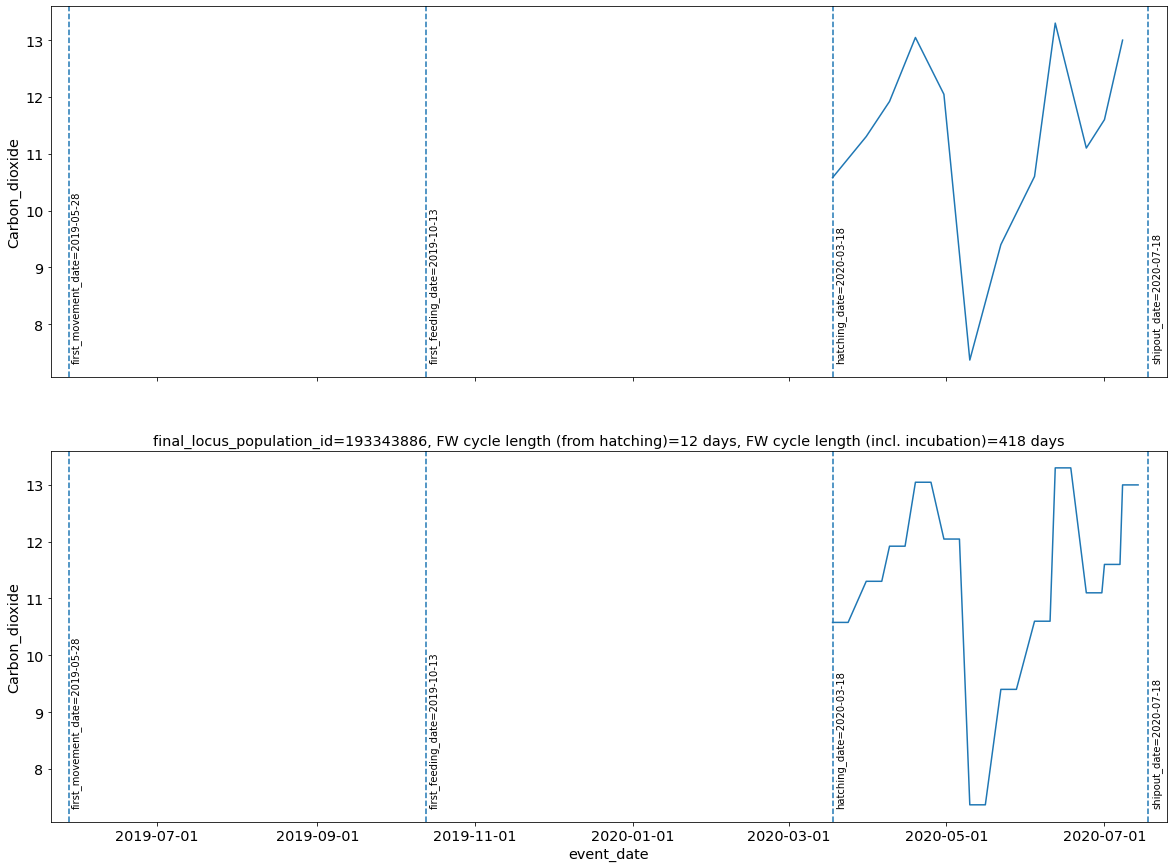

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


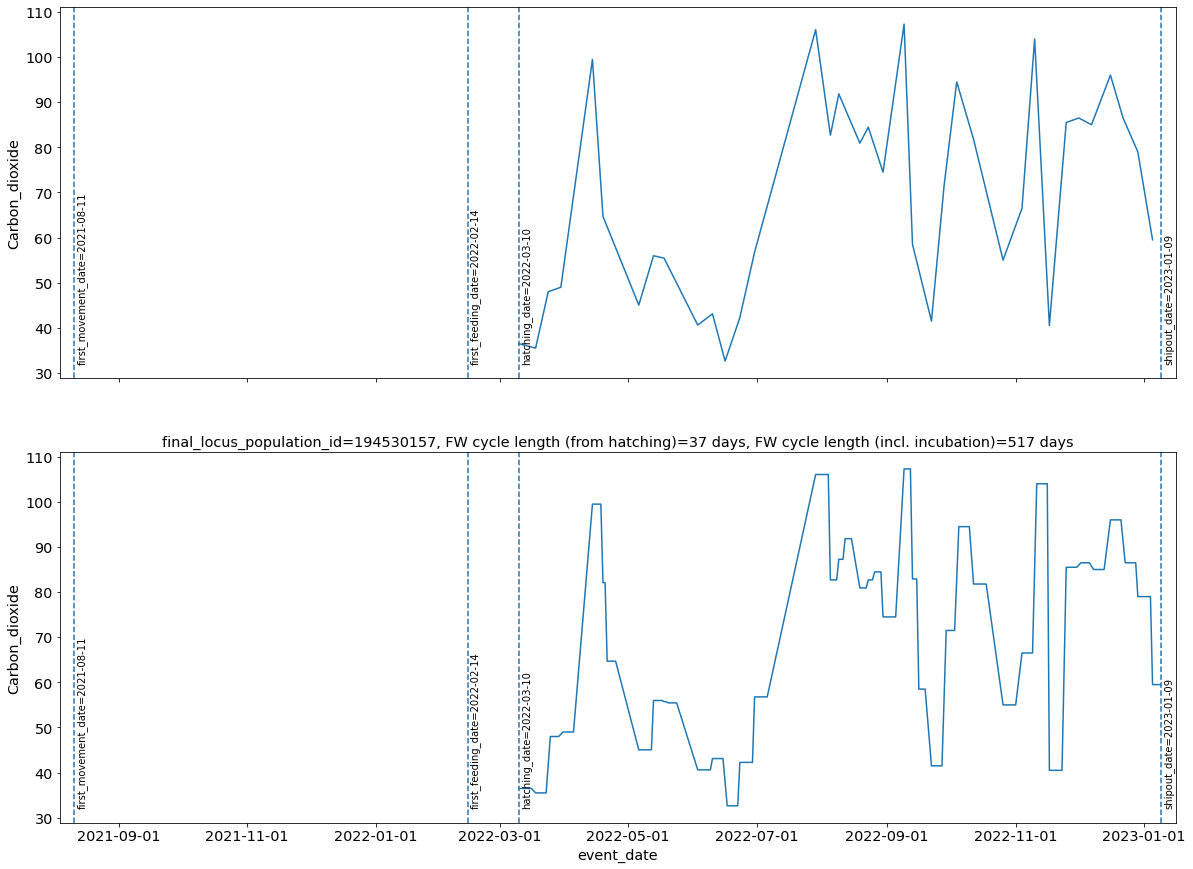

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


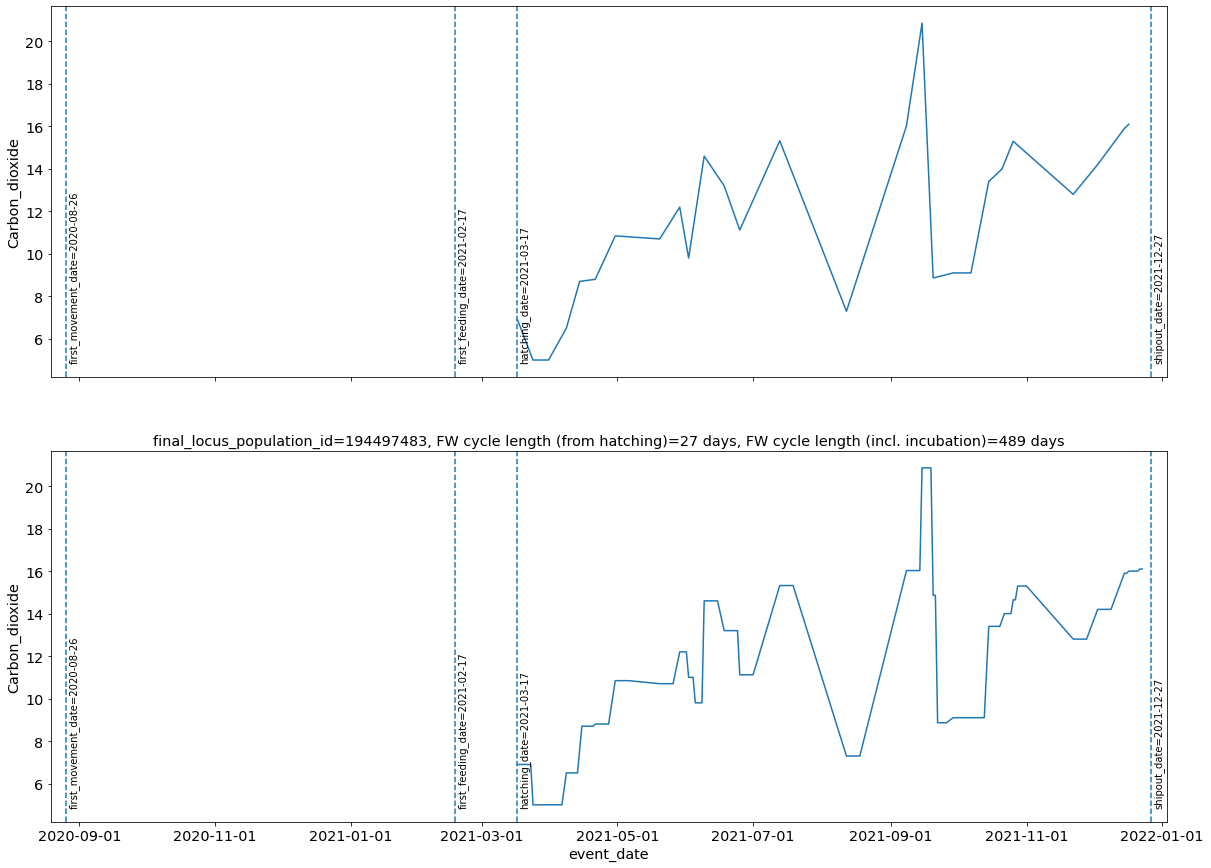

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


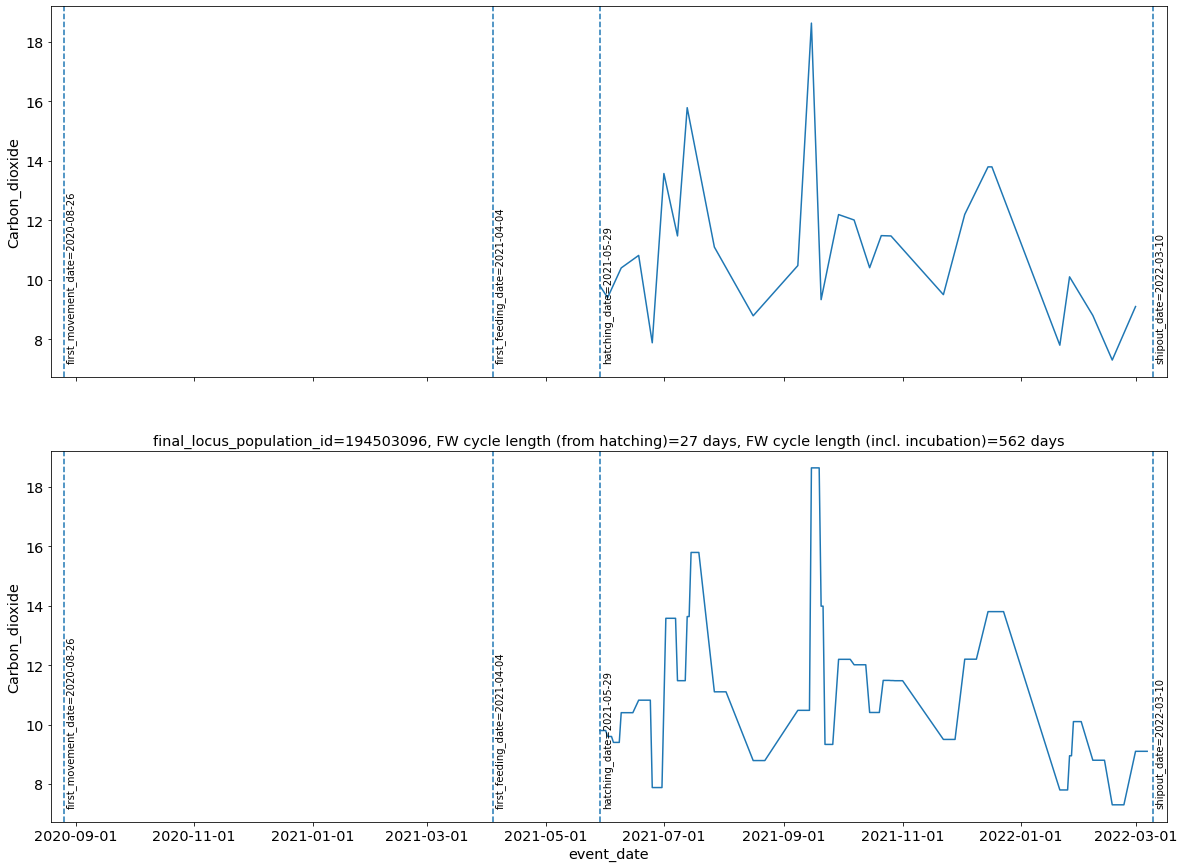

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


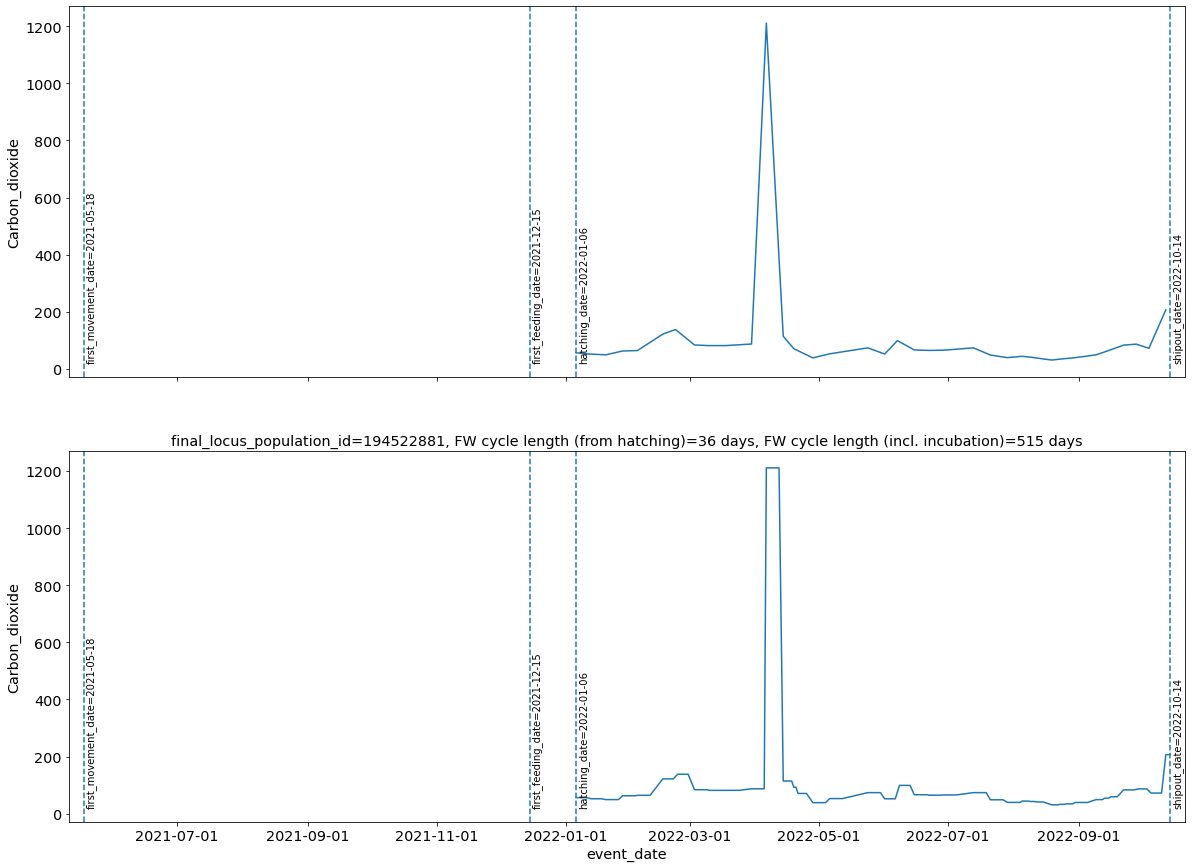

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


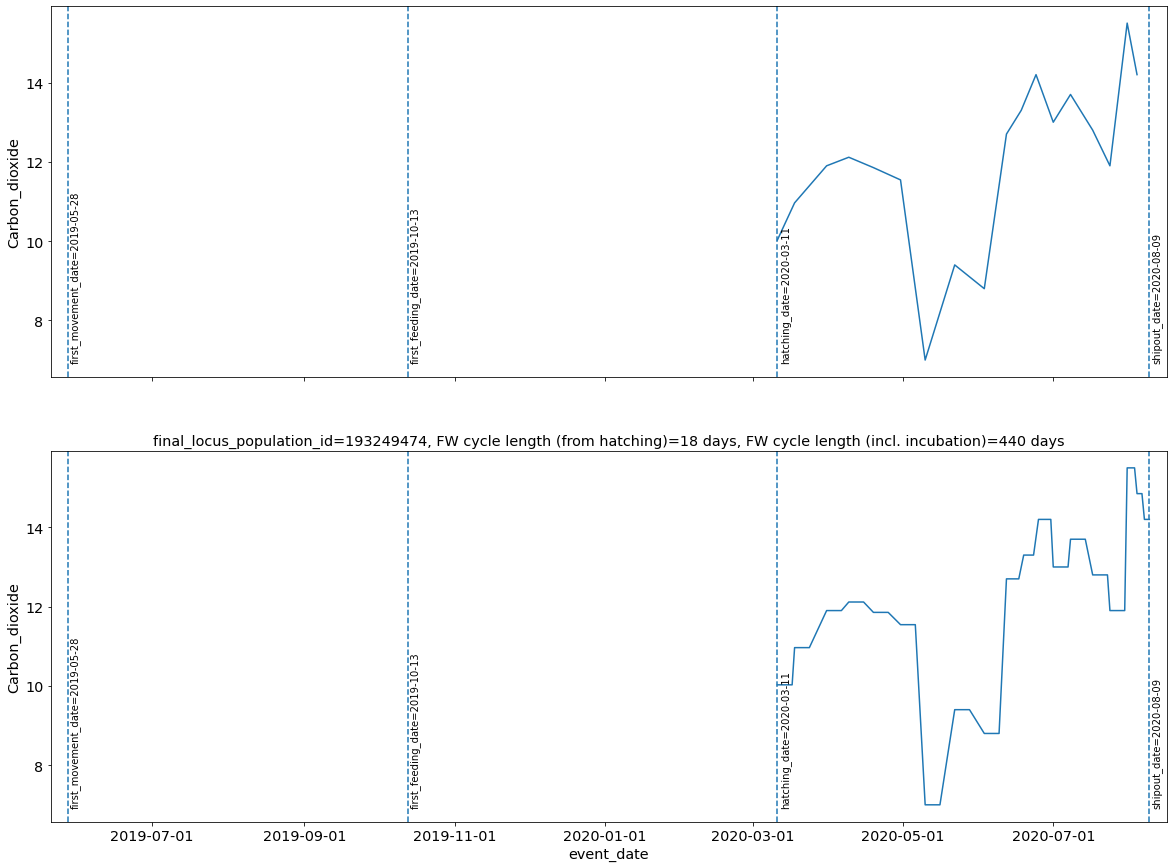

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


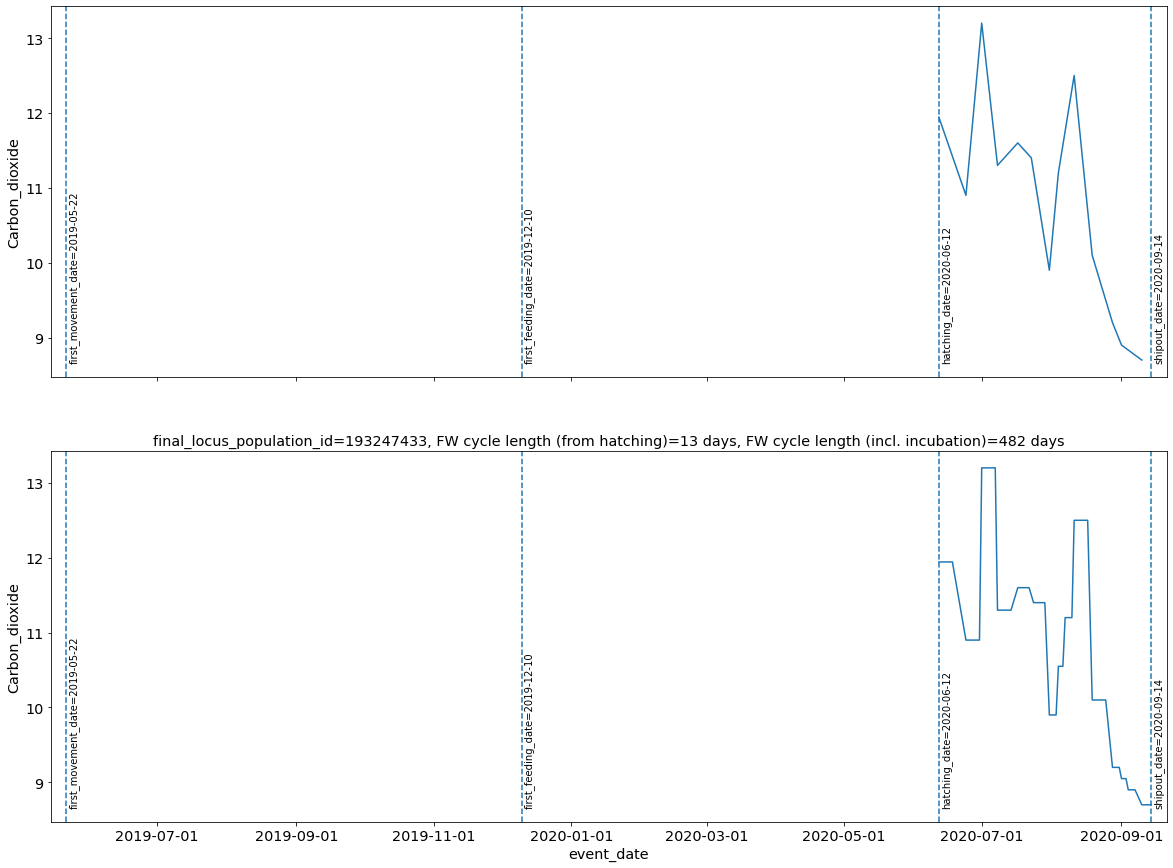

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


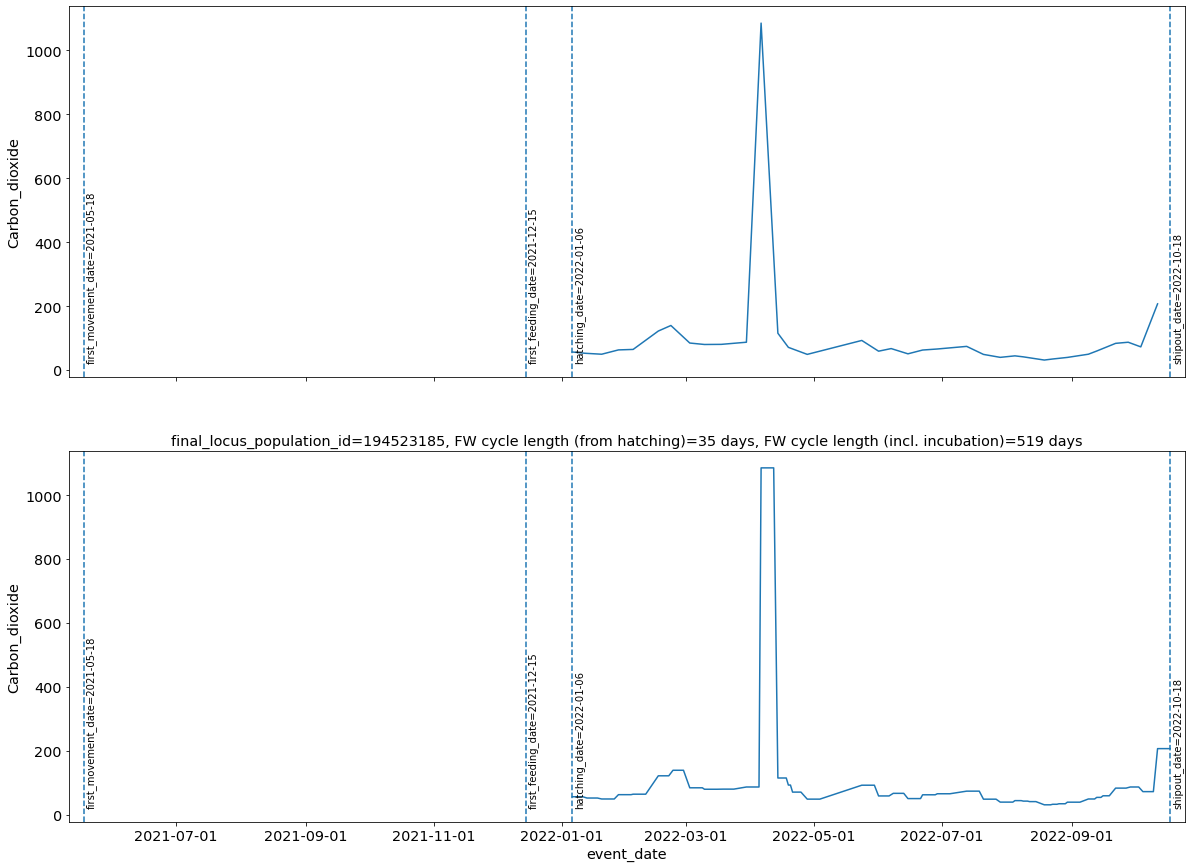

<ipython-input-61-93a11ff6eeae>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\


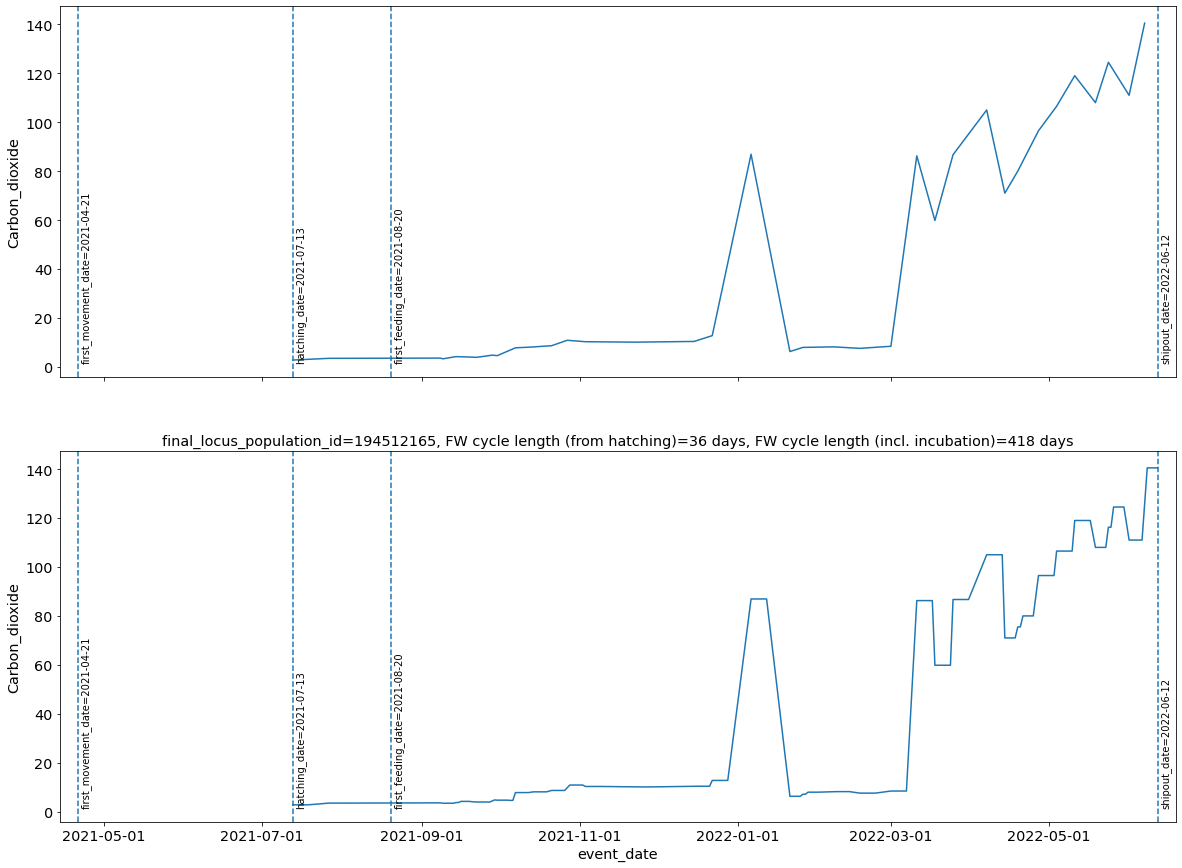

In [61]:
#plot temperature time series charts
j=0
for lp in full_cycles:
# or for all final_locus_population_id 
#for lp in dft_filled_ph.final_locus_population_id.unique():
    filtered_df = dft_filled_co2[dft_filled_co2.final_locus_population_id==lp]
    smoothed_filtered_df = filtered_df.copy()
    
    # replace values > 14 (like 72 instead of 7.2) with the mean of last weak
    smoothed_filtered_df.ph_value = smoothed_filtered_df.Carbon_dioxide.\
    apply(lambda x: x if (pd.isna(x) or x) < 14 else get_mean_last_week(smoothed_filtered_df, x))
    # weekly rolling window moving averge
    smoothed_filtered_df.Carbon_dioxide = smoothed_filtered_df.Carbon_dioxide.rolling(7, min_periods=1).mean()
    if filtered_df.Carbon_dioxide.isna().sum() != filtered_df.Carbon_dioxide.shape[0]:  # check if ph data is not np.nan-only
        j+=1
        if (j%100==0): 
            print(j)
        
        fig, axs = plt.subplots(2, 1, figsize=(20, 15), sharex='col')

        sns.lineplot(data=filtered_df, x='event_date',y='Carbon_dioxide', ax=axs[0])
        sns.lineplot(data=smoothed_filtered_df, x='event_date',y='Carbon_dioxide', ax=axs[1])

        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
        plt.title(chart_title)
        min_ph, smoothed_min_co2, = filtered_df.Carbon_dioxide.min(), smoothed_filtered_df.Carbon_dioxide.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        for ax in axs:
            ax.axis(xmin=first_movement_date-datetime.timedelta(days=7), xmax=shipout_date+datetime.timedelta(days=7))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            for ax, y_val in zip(axs, (min_ph, smoothed_min_co2)):
                ax.axvline(date,  linestyle='--')
                ax.text(date + datetime.timedelta(days=1), y_val, name+'='+date.strftime("%Y-%m-%d"), rotation=90)
        plt.show()
        fig.savefig(f'co2_vs_time_{chart_title}.png')
        plt.close()